#### Import libraries

In [1]:
import torch
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import Dataset
from PIL import Image
from skimage import io
from package import common
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

#### Prepare data

In [2]:
# Read csv file
file_path = "C:/Users/Esra/Desktop/Deep_Learning/Image_Classification/Fashion/Classify_ThreadUp_Images/data/ThredupData.csv"
df = pd.read_csv(file_path)
# df.info() # hi it's bailey hi bailey <3 <3 Hi it's Karina!hi Karina

In [3]:
# categories = df['Category_Type'].unique()
# len_categories = len(categories)
# df['Category_Type'].value_counts()
# df.head()
# df['Description'][1000]

In [4]:
# df[['Category_Type']].value_counts()

##### filter images

In [5]:
# Remove images from the dataframe that are not present in the folder

# get images downloaded
downloaded_files = os.listdir("data/StanfordJpegs/")

# # apply labels to the dataset
df['filename'] = df['Item_Id'].apply(lambda x: 'item' + str(x))
df['is_downloaded'] = df['filename'].apply(lambda x: True if x in downloaded_files else False)

# check to see if it's applied
df['is_downloaded'].value_counts()

is_downloaded
True     5250
False       3
Name: count, dtype: int64

In [6]:
cat_counts = df['Category_Type'].value_counts()
valid_cat = cat_counts[cat_counts>50].index.to_list()

In [7]:
len(valid_cat)

21

In [10]:
# remove items that didn't get downloaded and lower value counts than 50
df_load = df[(df['is_downloaded'] == True) & (df['Category_Type'].isin(valid_cat))].copy()

categories = df_load['Category_Type'].unique()
len_categories = len(categories)

#create a mapping
cat_to_int = {item:idx for idx, item in enumerate(categories)}
int_to_cat = {idx:item for idx, item in enumerate(categories)}

df_load['labels'] = df_load['Category_Type'].apply(lambda x: cat_to_int[x])
# pull only filename and label
df_load = df_load[['filename','labels']]
df_load.head()

,filename,labels
0,item110746148,0
1,item111845154,0
2,item111894473,0
3,item111978980,0
4,item112127758,0


#####  create pytorch dataset.

In [12]:
# # create pytorch dataset.
def read_image(img_path):
    return Image.open(img_path).convert('RGB')

class ThredupDataset(Dataset):
    def __init__(self, img_labels, img_dir, transform=None, target_transform=None):
        self.img_labels = img_labels
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def get_file(self,idx):
        label = self.img_labels.iloc[idx, 1]
        return os.path.join(self.img_dir, str(label), str(self.img_labels.iloc[idx, 0]))


    def __getitem__(self, idx):

        if isinstance(idx, slice):
        # Get the start, stop, and step from the slice
            
            #  return  [self[ii] for ii in range(idx.start, idx.stop, 1 if idx.step==None else idx.step)]
            return [self[ii] for ii in range(*idx.indices(len(self)))]
   
        
        label = self.img_labels.iloc[idx, 1]

        ## isn't designed to be indexed into an pull all these images????
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0]))
        image = read_image(img_path)
     
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

##### Dataloader

In [13]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                # transforms.Normalize((0.5,), (0.5,)),
                                ]) # change the first 0.5 to 0 (mean of the image) 

# Split the DataFrame into training and testing sets considering each label category
train_df, test_df = train_test_split(df_load, test_size=0.3, stratify=df_load['labels'], random_state=42)
# print(f'{len(train_df)=}, {len(test_df)=}')
train_data = ThredupDataset(
    img_labels=train_df,
    transform=transform,
    img_dir="data/StanfordJpegs/"
)

test_data = ThredupDataset(
    img_labels=test_df,
    transform=transform,
    img_dir="data/StanfordJpegs/"
)

In [21]:
# create data loader so images can be processed in batches.
trainloader = DataLoader(train_data, batch_size=64, shuffle=False)
testloader = DataLoader(test_data, batch_size=64, shuffle=False)
print(len(trainloader))

57


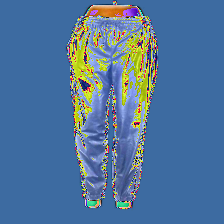

In [29]:
# to_pil = transforms.ToPILImage()
# to_pil(image[0,:])

<Axes: >

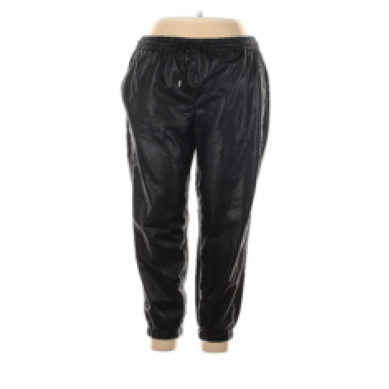

In [22]:
image, label = next(iter(trainloader))
image.shape
common.imshow(image[0,:])

21

In [39]:
vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)

for param in vgg.parameters():
    param.requires_grad = False

# Modify the last fully connected layer
in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(in_features, len_categories)  # change it to the number of classes in your task

vgg.classifier[0:6].requires_grad = True

criterion = nn.CrossEntropyLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(vgg.classifier.parameters(), lr=0.003) # weight_decay = 0.0001

# # Trainable parameters include the unfrozen convolutional layers and the modified classifier
# optimizer = optim.Adam(
#     [{'params': vgg.features.parameters()},
#      {'params': vgg.classifier.parameters()}],
#     lr=0.003
# )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
vgg.to(device)

cuda


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [15]:
import os
from dotenv import load_dotenv

notebook_directory = os.getcwd()

# Construct the absolute path to the api.env file
env_file_path = os.path.join(notebook_directory, "api.env")

# Load environment variables from the api.env file
load_dotenv(env_file_path)

# Access the API key
api_key = os.getenv("OPENAI_API_KEY")


In [12]:
!setx OPENAI_API_KEY api_key


SUCCESS: Specified value was saved.


In [20]:
# from openai import OpenAI
# client = OpenAI()

# completion = client.chat.completions.create(
#   model="gpt-3.5-turbo",
#   messages=[
#     {"role": "system", "content": "You are a poetic assistant, skilled in explaining complex programming concepts with creative flair."},
#     {"role": "user", "content": "Compose a poem that explains the concept of recursion in programming."}
#   ]
# )

print(completion.choices[0].message)

ChatCompletionMessage(content="In a coder's realm of endless codes,\nWhere logic shines and rhythm explodes,\nThere lies a concept, a looping tide,\nRecursive call, where brilliance abides.\n\nImagine a function, a marvelous breed,\nThat calls itself to accomplish its deed,\nA gift from programming gods, so grand,\nUnraveling mysteries with humble demand.\n\nIt starts with a base, a simple decree,\nA condition that sets the recursive spree,\nWhen satisfied, the magic begins to unfold,\nAnd recursion takes its infinite hold.\n\nLike a fractal's dance, it loops and repeats,\nA delicate waltz, where code spirits meet,\nEach step taken, a smaller case is seen,\nBreaking down problems, like a vibrant dream.\n\nThrough countless layers it travels deep,\nLike a cosmic journey, where secrets seep,\nDividing complexities into simpler flavors,\nRecursive call, the problem's savior.\n\nYet, beware the abyss, the infinite plight,\nFor without an end, it'll consume the light,\nA well-structured bas

In [40]:
epochs = 4
for e in range(epochs):
    vgg.train()
    running_loss = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        # Training pass
        optimizer.zero_grad()
        
        output = vgg(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 0.3216464570151609
Training loss: 0.15059839845880083
Training loss: 0.17137889299345643
Training loss: 0.16914669735553234


In [ ]:
#Save Weights or Load Saved Weights (optional)

#To save, uncomment below:
# torch.save(vgg.state_dict(), 'savedParams.pt')

#To load saved weights, uncomment below:
#vgg = models.vgg19()
#vgg.load_state_dict(torch.load('savedParams.pt'))

In [41]:
def accuracy_vals(loader_name):
    vgg.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader_name:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = vgg(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # print(inputs.shape)
            # print(inputs[predicted == labels])
            # break

    accuracy = correct / total
    print(f"Accuracy on set: {accuracy * 100:.2f}%")

In [42]:
accuracy_vals(testloader)

Accuracy on set: 94.84%


In [43]:
accuracy_vals(trainloader)   #it was 94.55% with 4 eopchs and weight decay

Accuracy on set: 94.96%
